In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

In [2]:
def c_amod15(a, power):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [ ]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [ ]:
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

for q in range(N_COUNT):
    qc.h(q)

qc.x(N_COUNT)

for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

qc.append(qft_dagger(N_COUNT), range(N_COUNT))

qc.measure(range(N_COUNT), range(N_COUNT))

In [ ]:
N_COUNT = 8
a = 7

def shor_N15(a=7):
    n_count = 8
    qc = QuantumCircuit(n_count + 4, n_count)

    qc.x(n_count + 3)  # |1⟩ en el registro de salida

    for q in range(n_count):
        qc.h(q)

    for q in range(n_count):
        qc.append(c_amod15(a, 2 ** q), [q] + [i + n_count for i in range(4)])

    qc.append(qft_dagger(n_count), range(n_count))
    qc.measure(range(n_count), range(n_count))
    return qc

In [6]:
def analyze_result(counts, n_count, N, a):
    measured = max(counts, key=counts.get)
    decimal = int(measured, 2)
    print(f"Resultado medido más probable: {measured} (decimal {decimal})")

    phase = decimal / (2 ** n_count)
    print(f"Aproximación decimal del período: {phase}")

    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Fracción aproximada: {frac} ⇒ posible período r = {r}")

    if pow(a, r, N) == 1:
        print(f"Validación: {a}^{r} ≡ 1 mod {N}")
        if r % 2 == 0:
            factor1 = np.gcd(pow(a, r//2) - 1, N)
            factor2 = np.gcd(pow(a, r//2) + 1, N)
            if factor1 not in [1, N] and factor2 not in [1, N]:
                print(f"p: {factor1}, q: {factor2}")
                return factor1, factor2
            else:
                print("No se encontraron factores no triviales.")
        else:
            print("r no es par. No se puede continuar.")
    else:
        print(f"{a}^{r} mod {N} ≠ 1 ⇒ r no es válido. Volver a correr.")

    return None, None

{'01000000': 233, '00000000': 269, '11000000': 242, '10000000': 280}
Resultado medido más probable: 10000000 (decimal 128)
Aproximación decimal del período: 0.5
Fracción aproximada: 1/2 ⇒ posible período r = 2
7^2 mod 15 ≠ 1 ⇒ r no es válido. Volver a correr.


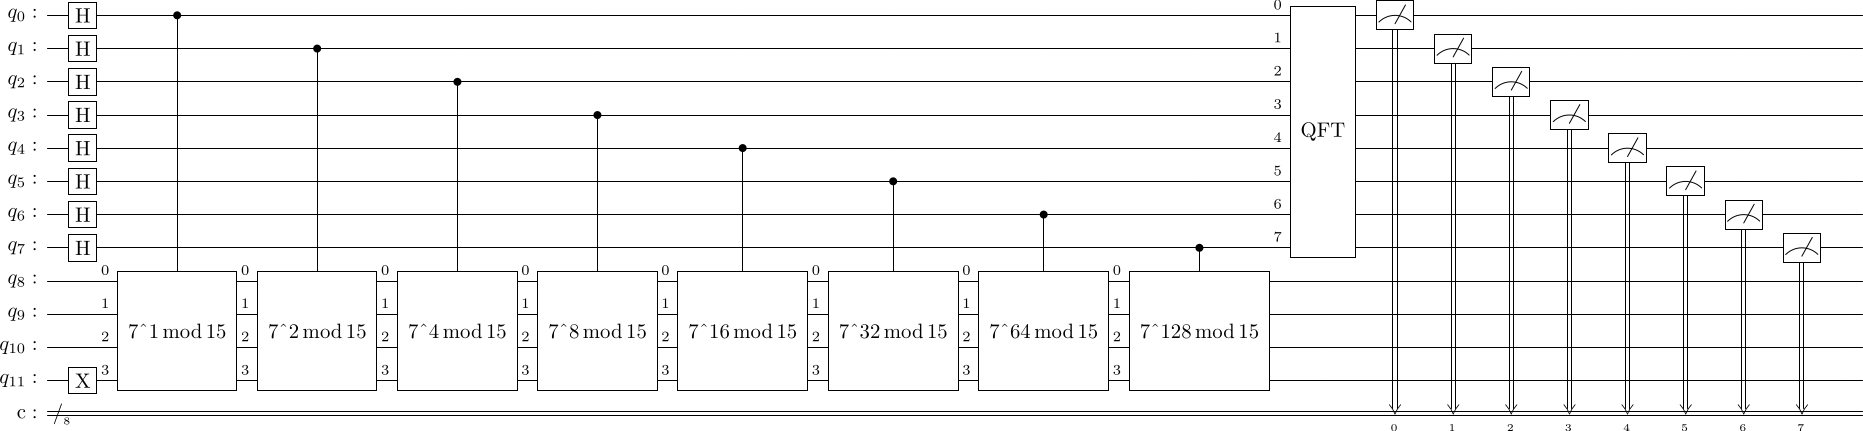

In [7]:
qc = shor_N15(a=7)

backend = AerSimulator()
qc_compiled = transpile(qc, backend)
job = backend.run(qc_compiled, shots=1024)
result = job.result()
counts = result.get_counts()
print(counts)

# Análisis de resultados
analyze_result(counts, n_count=8, N=15, a=7)
qc.draw(output="latex")